# Importing libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
import statsmodels.api as sm
from tqdm import tqdm

# Importing pypfopt for Portfolio Optimization


In [3]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Extracting data of NIFTY_50 stocks from 2015 Jan till current date

In [4]:
hub = pd.read_csv("ind_nifty50list (1).csv",index_col=0)
tickers=[]
for i in range(len(hub)):
    tickers.append(hub['Symbol'][i] + str(".NS"))

start= datetime(2015,1,1)
end = datetime.today()

ohlc_daily  = {}

for i in tqdm(range(len(tickers))):
    ohlc_daily[tickers[i]] = pdr.get_data_yahoo(tickers[i],start = start , end = end)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.22s/it]


# Defining function to take rolling historical data and generate  optimal portfolio weights

In [7]:
def optimal_weights(df):
    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)
    ef = EfficientFrontier(mu, S,weight_bounds=(0, 1))
    raw_weights = ef.max_sharpe()
    raw_weights = list(raw_weights.values())
    weights = np.array(raw_weights)
    return weights

In [8]:
def portfolio_returns(weights,df):
    portfolio = pd.DataFrame()
    portfolio['ret'] = np.sum(weights*df,axis=1)
    return portfolio

In [34]:
ohlc_monthly = {}
for ticker in tickers:
    ohlc_monthly[ticker]= ohlc_daily[ticker]['Adj Close'].resample('M').mean()

monthly_database = pd.DataFrame()
for ticker in tickers:
    monthly_database = pd.concat([monthly_database,ohlc_monthly[ticker]],axis=1)
monthly_database.columns= tickers
monthly_database = monthly_database.drop(monthly_database.index[0])

monthly_database_ret = monthly_database.pct_change()
# monthly_database_ret.dropna(inplace=True)

In [49]:
def Dynamic_Portfolio_Optimizer(df,df_ret,monthly_lookback):
    dynamic_portfolio = []
    for i in range(monthly_lookback,len(df)):
        weights = optimal_weights(monthly_database[i-monthly_lookback :i])
        test_portfolio = portfolio_returns(weights,df_ret[i:i+1])
        dynamic_portfolio.append(test_portfolio['ret'])
    return dynamic_portfolio

In [50]:
Dynamic_portfolio = Dynamic_Portfolio_Optimizer(df= monthly_database,df_ret= monthly_database_ret,monthly_lookback=6)
Dynamic_portfolio_arr = np.array(Dynamic_portfolio)
Dynamic_portfolio_df = pd.DataFrame(Dynamic_portfolio_arr)

Dynamic_portfolio_df.columns = ['ret']
Dynamic_portfolio_df['date'] = pd.date_range(start=datetime(2015,2,28), periods=len(Dynamic_portfolio_df), freq='M ')
Dynamic_portfolio_df = Dynamic_portfolio_df.set_index('date')

# Extracting historical benchmark data

In [43]:
def benchmark_performance(start,end):
    NIFTY = pdr.get_data_yahoo('^NSEI',start = start, end = end)    
    benchmark = pd.DataFrame()    
    benchmark['close'] = NIFTY['Adj Close']    
    return benchmark

In [71]:
index = benchmark_performance(start,end) 
index['ret'] = index['close'].pct_change()
index = index.dropna(axis=0)
index = index.resample('M').last()

,close,ret
Date,,
2015-01-31,8808.900391,-0.016024
2015-02-28,8844.599609,0.018511
2015-03-31,8491.000000,-0.000153
2015-04-30,8181.500000,-0.007069
2015-05-31,8433.650391,0.013782
...,...,...
2020-05-31,9580.299805,0.009505
2020-06-30,10302.099609,-0.000999
2020-07-31,11073.450195,-0.002585


# Performance analysis function

In [73]:
def performance_analysis(df,window,rf,leverage):    
    
    df['cum_return'] = (1+df['ret']*leverage).cumprod()
    Cumm_Ret = (df['cum_return'][-1]-1)
    
    n = len(df)/(12)   
    CAGR = ((df["cum_return"][-1])**(1/n) - 1)
    
    df['rolling_volatility'] = df['ret'].rolling(window).std()
    volatility =  df['ret'].std()*np.sqrt(12)
    
    df['rolling_sharpe'] = df['ret'].rolling(window).mean()/df['ret'].rolling(window).std()*np.sqrt(window)
    sr = (CAGR - rf)/volatility
    
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    
    df["Year"] = df.index.map(lambda x: x.year)
    df["Month"] = df.index.map(lambda x: x.strftime("%b"))
    pt = df.pivot_table(index="Month",columns="Year",values="ret", aggfunc="sum").fillna(0)
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    pt = pt.reindex(months)    
    sns.heatmap(pt, annot=True, cmap="RdYlGn")
    
    performance_df = pd.DataFrame([Cumm_Ret*100,CAGR*100,volatility,sr,max_dd*100],index=["Cumm_Return","Annual_Return","Volatility","Sharpe Ratio","Max Drawdown"])      
    print(performance_df)

    return df

# Comparing benchmark and dynamic portfolio

                       0
Cumm_Return    16.099984
Annual_Return   2.630196
Volatility      0.038617
Sharpe Ratio    0.681105
Max Drawdown    5.771546


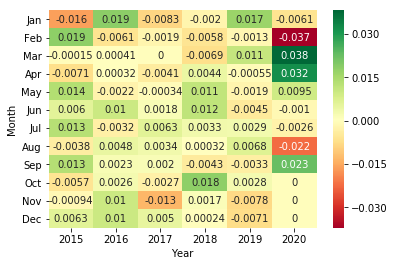

In [74]:
index_performance = performance_analysis(df = index,window = 6 ,rf = 0,leverage=1)

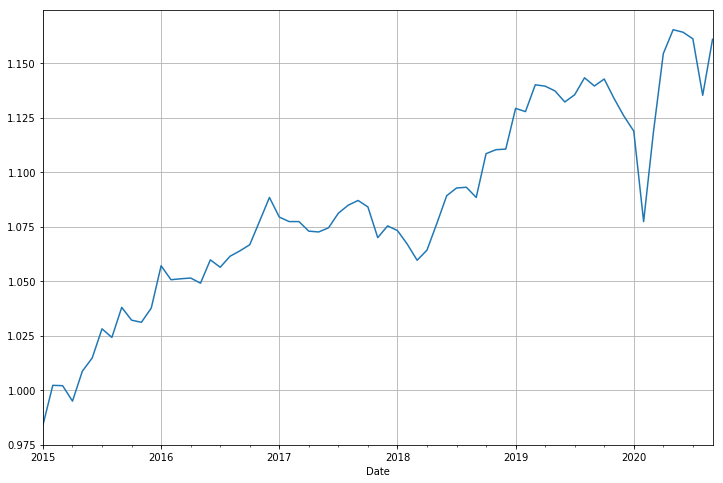

In [75]:
index_performance['cum_return'].plot(figsize=(12,8),grid=True)

                        0
Cumm_Return    210.667260
Annual_Return   24.532583
Volatility       0.157545
Sharpe Ratio     1.557181
Max Drawdown    17.544893


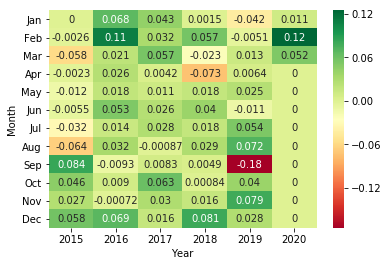

In [76]:
Dynamic_portfolio_perfomance = performance_analysis(df=Dynamic_portfolio_df,window=20,rf=0,leverage= 1)

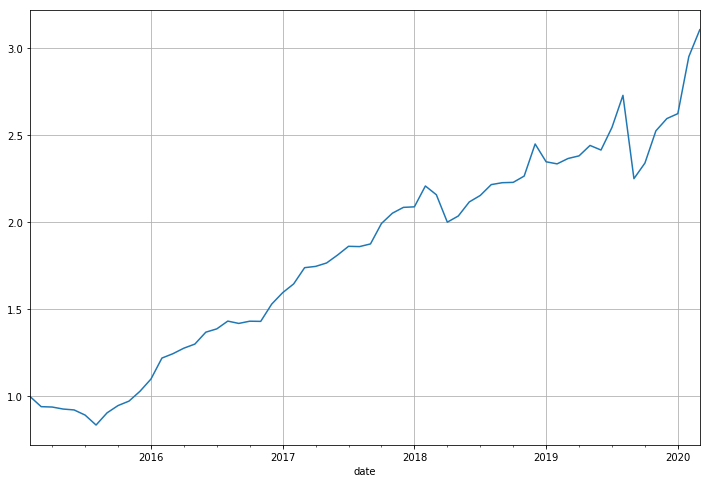

In [77]:
Dynamic_portfolio_perfomance['cum_return'].plot(figsize=(12,8),grid=True)